# Identify Pneumothorax Disease in Chest X-rays

A pneumothorax is an abnormal collection of air in the pleural space between the lung and the chest wall [2]. This air pushes on the outside of the lung making it collapse. A pneumothorax can be a complete lung collapse or a collapse of only a portion of the lung [3]. The symptoms of a pneumothorax typically include sudden onset of sharp, one-sided chest pain and shortness of breath. A pneumothorax can be caused by a blunt or penetrating chest injury, certain medical procedures and damage from underlying lung disease. It may also occur for no obvious reason [2][3]. In some occasions, a pneumothorax can be a life-threatening condition [3].

A pneumothorax is generally diagnosed using a chest X-ray [4]. However, they can sometimes be difficult to confirm from chest X-rays[1].

The aim of this project is to predict the existence of a pneumothorax in a test image using a convolutional neural network and indicate the extent of the condition using binary masks and encode them using run-length-encoded (RLE) masks.

In [1]:
# Importing the libraries to use.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pydicom
import os

from glob import glob
from collections import defaultdict
from tqdm import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Printing dataset directories.
dataset_path = "./dataset"
rles_path = "train-rle.csv"
print("The dataset folder has two directories:")
print(os.listdir(dataset_path))

# Import the training and test set
train_set = sorted(glob(dataset_path + '/dicom-images-train/*/*/*.dcm'))
test_set = sorted(glob(dataset_path + '/dicom-images-test/*/*/*.dcm'))
rles = pd.read_csv(rles_path)

# Printing the number of images in the training and testing sets
print("\nThe training set has %d images." %(len(train_set)))
print("The Testing set has %d images." %(len(test_set)))

# Importing RLEs

rles = pd.read_csv(rles_path)
rles.columns = ['ImageId', 'EncodedPixels']
print("\nRLES data:")
display(rles.head())

The dataset folder has two directories:
['dicom-images-test', 'dicom-images-train']

The training set has 10675 images.
The Testing set has 1372 images.

RLES data:


ImageId  \
0  1.2.276.0.7230010.3.1.4.8323329.5597.151787518...   
1  1.2.276.0.7230010.3.1.4.8323329.12515.15178752...   
2  1.2.276.0.7230010.3.1.4.8323329.4904.151787518...   
3  1.2.276.0.7230010.3.1.4.8323329.32579.15178751...   
4  1.2.276.0.7230010.3.1.4.8323329.32579.15178751...   

                                       EncodedPixels  
0                                                 -1  
1                                                 -1  
2   175349 7 1013 12 1009 17 1005 19 1003 20 1002...  
3   407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...  
4   252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...

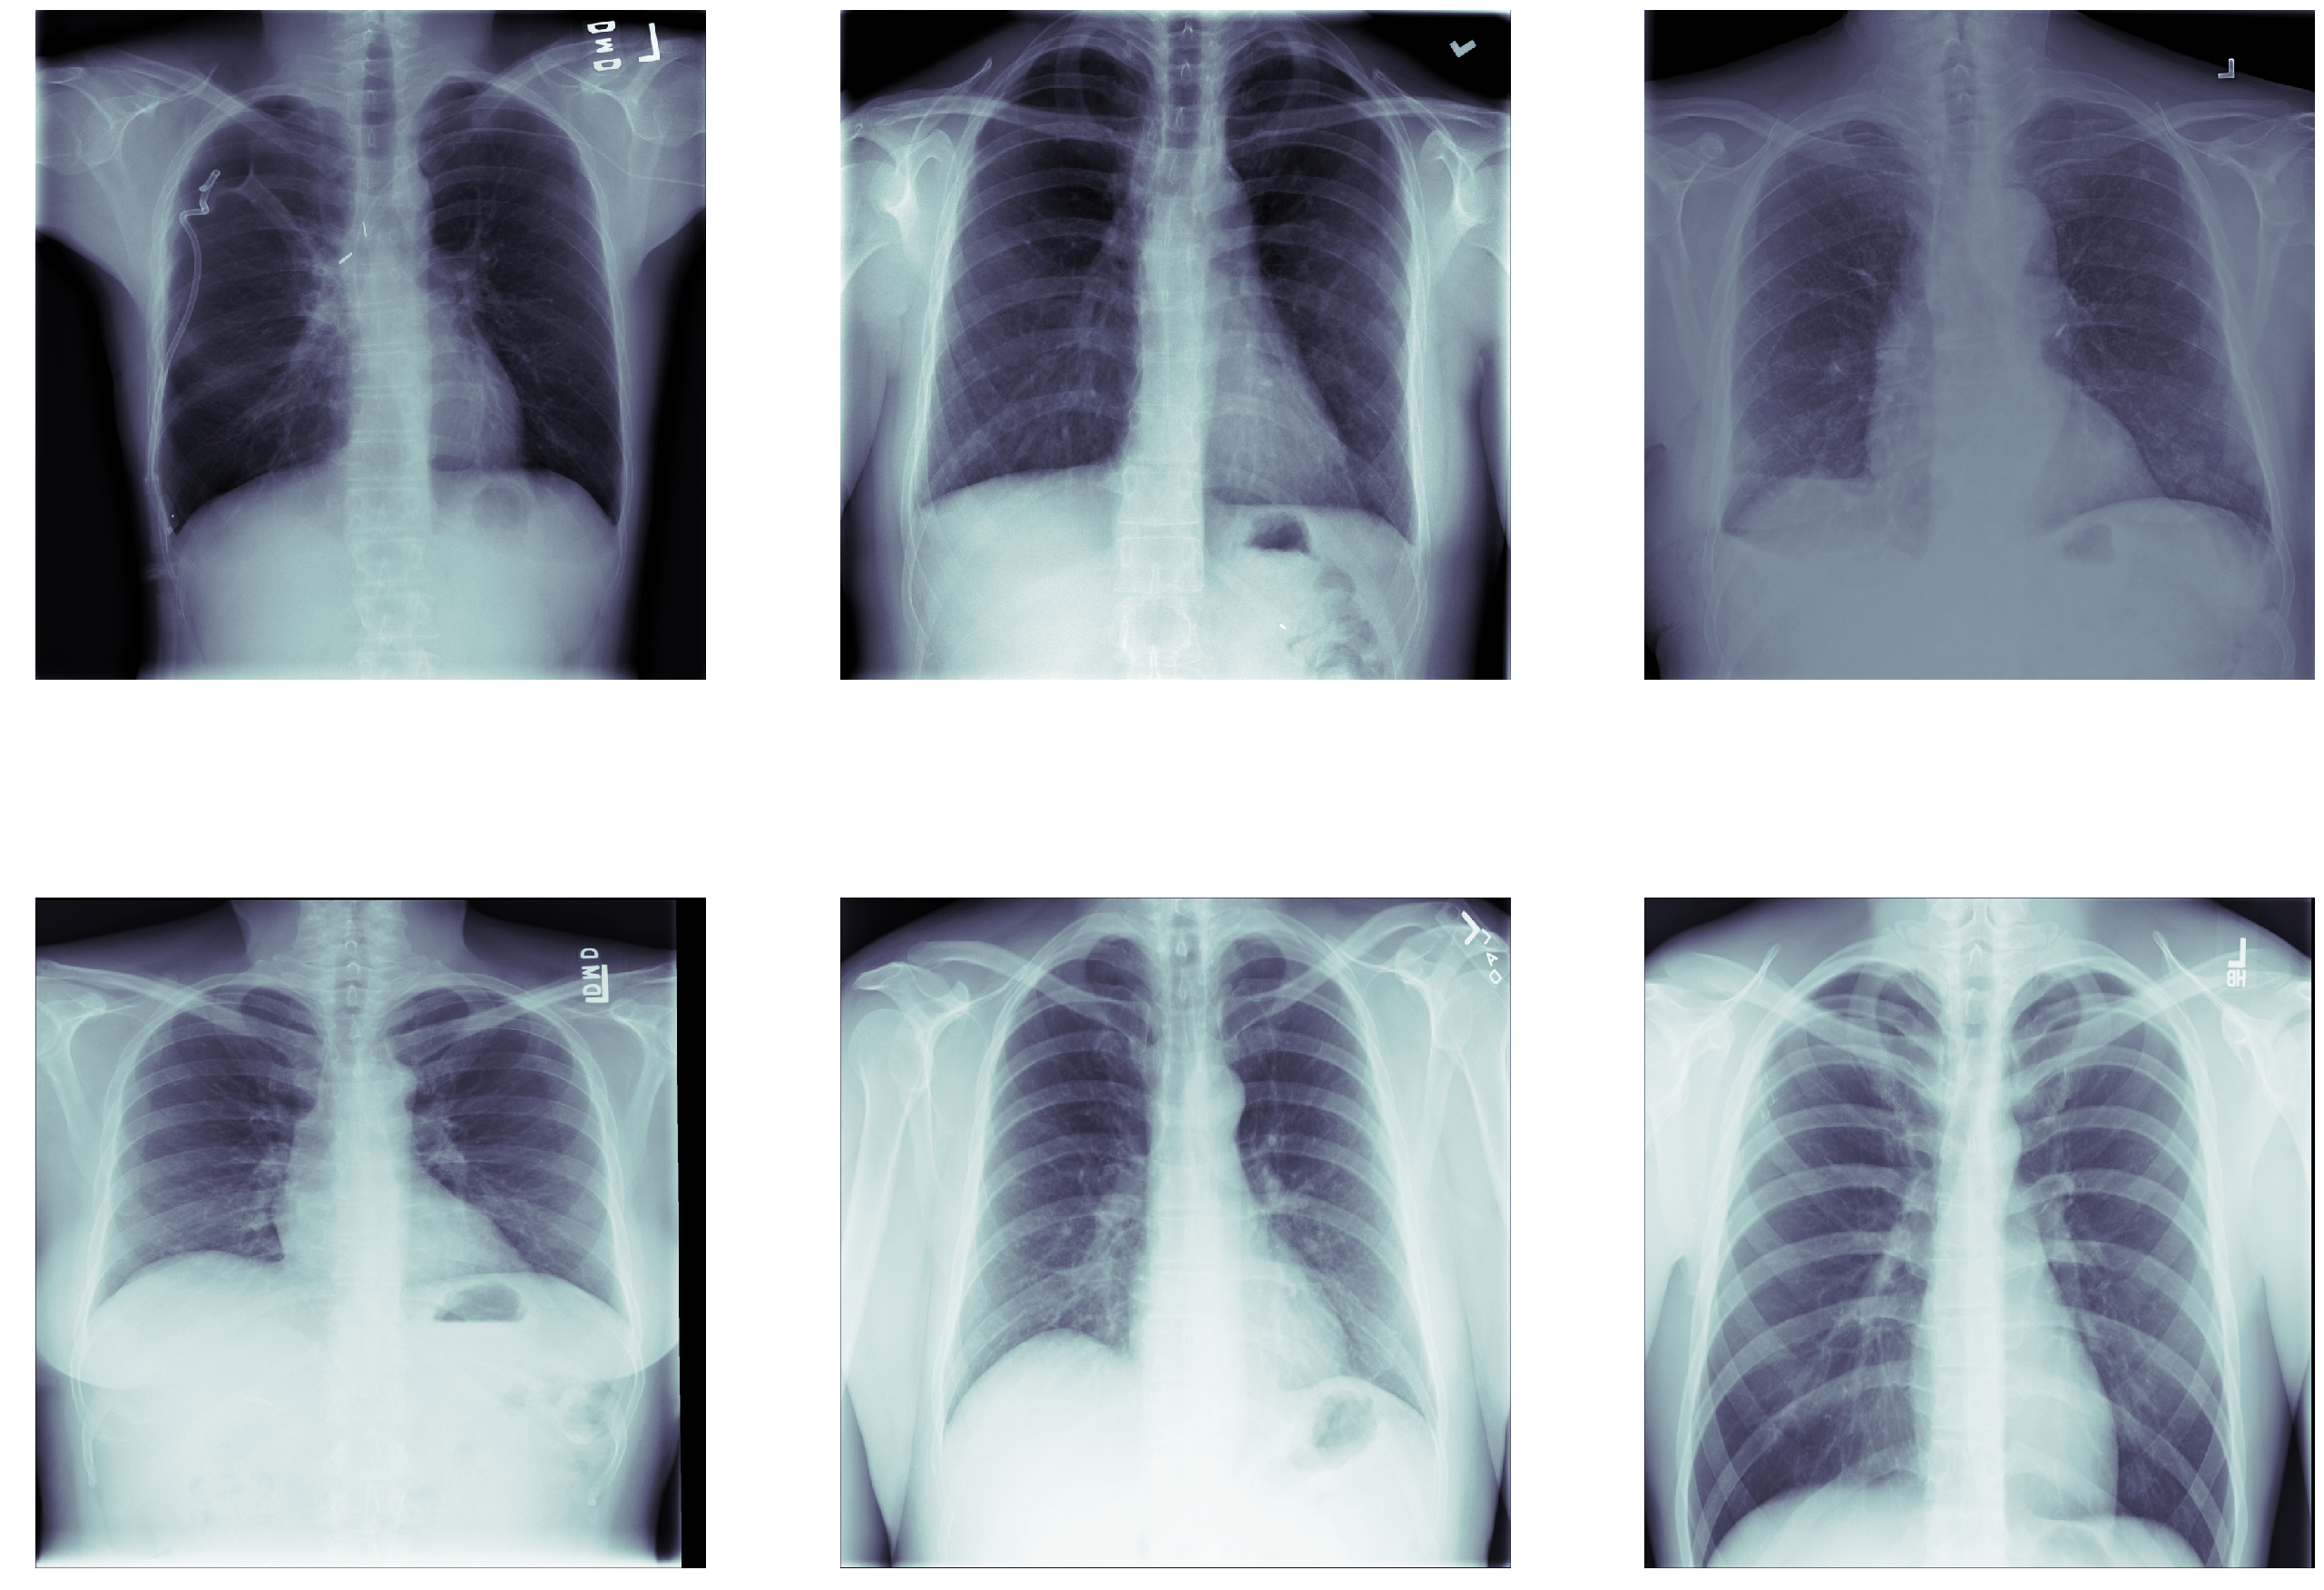

In [3]:
# Printing image samples

rows, columns = 2, 3
fig = plt.figure(figsize = (45, 33))

for i in range(1, 7):
    image_file = np.random.choice(test_set)
    img = pydicom.read_file(image_file).pixel_array
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='bone')
    plt.axis('off')
plt.show()

In [4]:
# Passing DICOM data and returning relevant fields

def dicom_dataset_to_dict(dicom_data, file_path, rles, encoded_pixels = True):
    dicom_dict = {}  
    
    # Parse fields with meaningful information
    dicom_dict['patient_name'] = dicom_data.PatientName
    dicom_dict['patient_id'] = dicom_data.PatientID
    dicom_dict['patient_age'] = int(dicom_data.PatientAge)
    dicom_dict['patient_sex'] = dicom_data.PatientSex
    dicom_dict['pixel_spacing'] = dicom_data.PixelSpacing
    dicom_dict['file_path'] = file_path
    dicom_dict['id'] = dicom_data.SOPInstanceUID
    
    # Check for annotaion in training set
    if encoded_pixels:
        encoded_pixels_list = rles[rles['ImageId'] == dicom_data.SOPInstanceUID]['EncodedPixels'].values       
        pneumothorax = False
        for encoded_pixels in encoded_pixels_list:
            if encoded_pixels != ' -1':
                pneumothorax = True
        
        # format the data
        dicom_dict['encoded_pixels_list'] = encoded_pixels_list
        dicom_dict['has_pneumothorax'] = pneumothorax
        dicom_dict['encoded_pixels_count'] = len(encoded_pixels_list)
        
    return dicom_dict

In [5]:
# Parse training data

train_data_df = pd.DataFrame()
train_data_list = []
for file_path in tqdm(train_set):
    dicom_data = pydicom.dcmread(file_path)
    train_data = dicom_dataset_to_dict(dicom_data, file_path, rles)
    train_data_list.append(train_data)
train_data_df = pd.DataFrame(train_data_list)

100%|██████████| 10675/10675 [00:34<00:00, 309.81it/s]


In [6]:
display(train_data_df.head())

encoded_pixels_count encoded_pixels_list  \
0                     1               [ -1]   
1                     1               [ -1]   
2                     1               [ -1]   
3                     1               [ -1]   
4                     1               [ -1]   

                                           file_path  has_pneumothorax  \
0  ./dataset/dicom-images-train/1.2.276.0.7230010...             False   
1  ./dataset/dicom-images-train/1.2.276.0.7230010...             False   
2  ./dataset/dicom-images-train/1.2.276.0.7230010...             False   
3  ./dataset/dicom-images-train/1.2.276.0.7230010...             False   
4  ./dataset/dicom-images-train/1.2.276.0.7230010...             False   

                                                  id  patient_age  \
0  1.2.276.0.7230010.3.1.4.8323329.1000.151787516...           38   
1  1.2.276.0.7230010.3.1.4.8323329.10000.15178752...           10   
2  1.2.276.0.7230010.3.1.4.8323329.10001.15178752...           50   
3  1.2.276.0.7230010.3.1.4.8323329.10002.15178752...           68   
4  1.2.276.0.7230010.3.1.4.8323329.10003.15178752...           65   

                             patient_id                          patient_name  \
0  17d405a3-a0d2-4901-b33a-63906aa48d9f  17d405a3-a0d2-4901-b33a-63906aa48d9f   
1  8ab1ffda-8b65-4914-95d6-2e549e328666  8ab1ffda-8b65-4914-95d6-2e549e328666   
2  bfef51d3-6541-4792-bac1-d21d41ee60fd  bfef51d3-6541-4792-bac1-d21d41ee60fd   
3  d19d956f-4ddd-4688-81ff-909c85e0e2d9  d19d956f-4ddd-4688-81ff-909c85e0e2d9   
4  cf71a760-f693-4ccf-acd4-a41ff4845a5f  cf71a760-f693-4ccf-acd4-a41ff4845a5f   

  patient_sex   pixel_spacing  
0           M  [0.168, 0.168]  
1           F  [0.139, 0.139]  
2           F  [0.168, 0.168]  
3           F  [0.139, 0.139]  
4           M  [0.168, 0.168]

In [7]:
# Parse test data

test_data_df = pd.DataFrame()
test_data_list = []
for file_path in tqdm(test_set):
    dicom_data = pydicom.dcmread(file_path)
    test_data = dicom_dataset_to_dict(dicom_data, file_path, rles)
    test_data_list.append(test_data)
test_data_df = pd.DataFrame(test_data_list)

100%|██████████| 1372/1372 [00:04<00:00, 306.88it/s]


In [8]:
display(test_data_df.head(5))

encoded_pixels_count encoded_pixels_list  \
0                     0                  []   
1                     0                  []   
2                     0                  []   
3                     0                  []   
4                     0                  []   

                                           file_path  has_pneumothorax  \
0  ./dataset/dicom-images-test/1.2.276.0.7230010....             False   
1  ./dataset/dicom-images-test/1.2.276.0.7230010....             False   
2  ./dataset/dicom-images-test/1.2.276.0.7230010....             False   
3  ./dataset/dicom-images-test/1.2.276.0.7230010....             False   
4  ./dataset/dicom-images-test/1.2.276.0.7230010....             False   

                                                  id  patient_age  \
0  1.2.276.0.7230010.3.1.4.8323329.5797.151787519...           81   
1  1.2.276.0.7230010.3.1.4.8323329.5798.151787519...           26   
2  1.2.276.0.7230010.3.1.4.8323329.5799.151787519...           58   
3  1.2.276.0.7230010.3.1.4.8323329.580.1517875163...           51   
4  1.2.276.0.7230010.3.1.4.8323329.5800.151787519...           68   

                             patient_id                          patient_name  \
0  d6a76eb1-d814-46b1-a375-fcc796d2b0b0  d6a76eb1-d814-46b1-a375-fcc796d2b0b0   
1  ec2642f0-6721-4ceb-bce7-c3a124375a9c  ec2642f0-6721-4ceb-bce7-c3a124375a9c   
2  0f9f8029-f0e2-4300-9f8e-835b18b5d281  0f9f8029-f0e2-4300-9f8e-835b18b5d281   
3  5d2ea647-162e-4e4e-b894-e97f1f22871d  5d2ea647-162e-4e4e-b894-e97f1f22871d   
4  4a61fd76-a241-40ba-a32c-ec5e9a7704c2  4a61fd76-a241-40ba-a32c-ec5e9a7704c2   

  patient_sex                               pixel_spacing  
0           M  [0.14300000000000002, 0.14300000000000002]  
1           M  [0.14300000000000002, 0.14300000000000002]  
2           M                              [0.168, 0.168]  
3           F  [0.19431099999999998, 0.19431099999999998]  
4           F                              [0.171, 0.171]

### Plotting the data

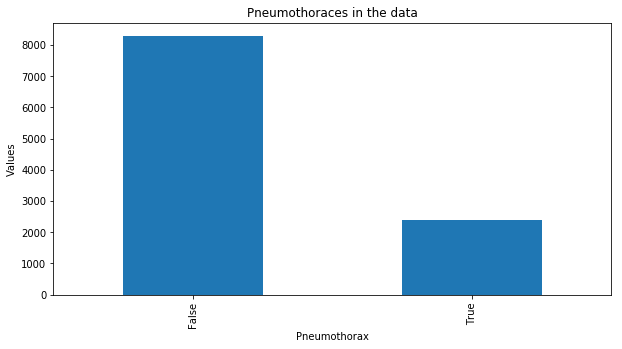

In [9]:
fig = plt.figure(figsize = (10, 5))
train_data_df['has_pneumothorax'].value_counts().plot.bar()
plt.title("Pneumothoraces in the data")
plt.xlabel("Pneumothorax")
plt.ylabel("Values")
plt.show()

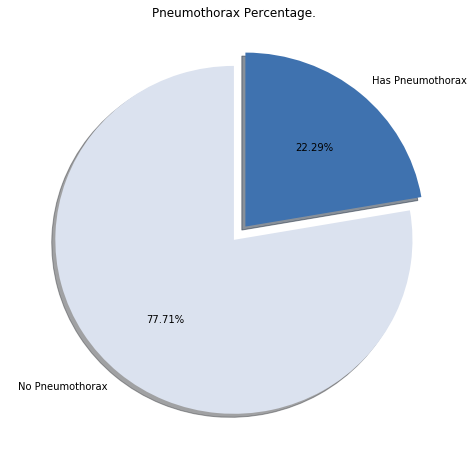

In [10]:
#Data to plot
train_data_to_plot = train_data_df['has_pneumothorax'].value_counts(sort = True)
labels = ('No Pneumothorax', "Has Pneumothorax")
colors = ('#dbe2ef', '#3f72af')
rcParams['figure.figsize'] = 8,8

#Plotting the data
plt.pie(train_data_to_plot, labels = labels, colors = colors, explode = [0,0.1], startangle = 90, autopct = '%1.2f%%', shadow = True)
plt.title('Pneumothorax Percentage.')
plt.show()

### Plotting pneumothorax by sex

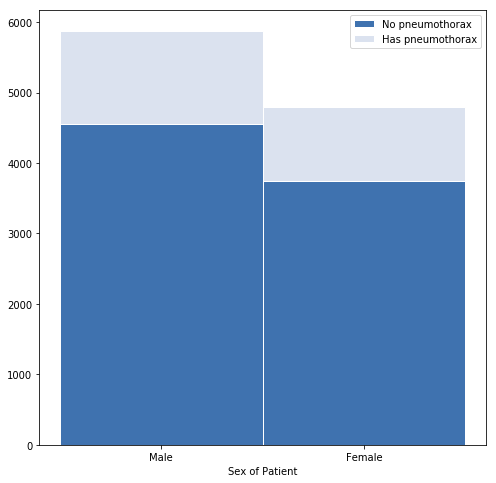

In [11]:
male_train = train_data_df[train_data_df['patient_sex']=='M']
female_train = train_data_df[train_data_df['patient_sex']=='F']

male_negative = len(male_train[male_train['has_pneumothorax']==0])
female_negative = len(female_train[female_train['has_pneumothorax']==0])
male_positive = len(male_train[male_train['has_pneumothorax']==1])
female_positive = len(female_train[female_train['has_pneumothorax']==1])

r = [0, 1]
barWidth = 1
x_labels = ["Male", "Female"]

bar1 = [male_negative, female_negative]
bar2 = [male_positive, female_positive]
bar_height = np.add(bar1, bar2).tolist()

plt.bar(r, bar1, color='#3f72af', edgecolor='white', width=barWidth)
plt.bar(r, bar2, bottom=bar1, color='#dbe2ef', edgecolor='white', width=barWidth)
plt.xticks(r, x_labels)
plt.xlabel("Sex of Patient")
plt.legend(loc='upper right', labels =['No pneumothorax', 'Has pneumothorax'])

plt.show()

In [12]:
print('female_positive:', female_positive)
print('female_negative:', female_negative)
print('male_positive:', male_positive)
print('male_negative:', male_negative)

female_positive: 1053
female_negative: 3742
male_positive: 1326
male_negative: 4554


### References

- [DICOM Processing and Segmentation in Python](https://www.raddq.com/dicom-processing-segmentation-visualization-in-python)
- [Getting to know DICOM and the data](https://www.kaggle.com/schlerp/getting-to-know-dicom-and-the-data/data)
- [Mask-rcnn with augmentation and multiple masks](https://www.kaggle.com/abhishek/mask-rcnn-with-augmentation-and-multiple-masks#Convert-Model-to-Evaluation-Mode)
- [Intro - chest xray, DICOM, viz, U-nets - full data](https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data)
- [Full dataset](https://www.kaggle.com/seesee/full-dataset)
- [Finding Pneumo part 1 EDA and UNET](https://www.kaggle.com/ekhtiar/finding-pneumo-part-1-eda-and-unet)
- [Read DICOM and ploting using matplotlib](https://pydicom.github.io/pydicom/stable/auto_examples/input_output/plot_read_dicom.html)
- [Converting a dicom dataset to a standard python dictionary](https://github.com/pydicom/pydicom/issues/319)
- [Image Pre-processing for Chest X-ray](https://www.kaggle.com/seriousran/image-pre-processing-for-chest-x-ray)